In [6]:
import numpy as np
from numpy import sqrt,pi,e,cos,sin,tan
import matplotlib.pyplot as plt
import math
import random as rm
from numpy.linalg import matrix_power
from scipy.linalg import expm, eig
from scipy.optimize import minimize, basinhopping
from scipy.sparse import issparse,eye
from scipy.sparse import linalg as slg
import time

In [7]:
## Precompute some expressions
def c1(J,gamma,i):
    return np.prod(list(map(lambda x: cos(2*gamma*x)\
                            , J[i])))
def c2plus(J, gamma, i,j):
    Jplus = J[i]+J[j]
    Jplus[i] = Jplus[j]=0
    return np.prod(list(map(lambda x: cos(2*gamma*x)\
                            , Jplus)))

def c2minus(J, gamma, i,j):
    Jminus = J[i]-J[j]
    Jminus[i] = Jminus[j]=0
    return np.prod(list(map(lambda x: cos(2*gamma*x)\
                            , Jminus)))
### Now, compute the expectation in state |gamma>
def ergX(J, K, gamma, i):
    return cos(2*gamma*K[i])*c1(J,gamma,i)
def ergY(J, K, gamma, i):
    return sin(2*gamma*K[i])*c1(J,gamma,i)
def ergXX(J, K, gamma, i,j):
    return 0.5*(cos(2*gamma*(K[i]+K[j]))*c2plus(J,gamma,i,j)\
               +cos(2*gamma*(K[i]-K[j]))*c2minus(J,gamma,i,j))
def ergYY(J, K, gamma, i,j):
    return 0.5*(cos(2*gamma*(K[i]-K[j]))*c2minus(J,gamma,i,j)\
               -cos(2*gamma*(K[i]+K[j]))*c2plus(J,gamma,i,j))
def ergXY(J, K, gamma, i,j):
    return 0.5*(sin(2*gamma*(K[i]+K[j]))*c2plus(J,gamma,i,j)\
               +sin(2*gamma*(K[i]-K[j]))*c2minus(J,gamma,i,j))
def ergYZ(J, K, gamma, i,j):
    return cos(2*gamma*K[i])*sin(2*gamma*J[i,j])*c1(J,gamma,i)
def ergZX(J, K, gamma, i,j):
    return sin(2*gamma*K[i])*sin(2*gamma*J[i,j])*c1(J,gamma,i)

### Finally, compute expectation in state |beta, gamma>
def qaoaX(J, K, beta, gamma, i): 
    return ergX(J, K, gamma, i)
def qaoaY(J, K, beta, gamma, i):
    return cos(2*beta)*ergY(J, K, gamma, i)
def qaoaZ(J, K, beta, gamma, i):
    return -sin(2*beta)*ergY(J, K, gamma, i)
def qaoaXX(J, K, beta, gamma, i,j):
    return ergXX(J, K, gamma, i,j)
def qaoaYY(J, K, beta, gamma, i,j):
    c = cos(2*beta)
    s = sin(2*beta)
    return c**2*ergYY(J, K, gamma, i,j)\
    +c*s*ergYZ(J, K, gamma, i,j)\
    +c*s*ergYZ(J, K, gamma, j,i)
def qaoaZZ(J, K, beta, gamma, i,j):
    c = cos(2*beta)
    s = sin(2*beta)
    return -c*s*ergYZ(J, K, gamma, i,j)\
    -c*s*ergYZ(J, K, gamma, j,i)\
    +s**2*ergYY(J, K, gamma, i,j)
def qaoaXY(J, K, beta, gamma, i,j):
    return cos(2*beta)*ergXY(J, K, gamma, i,j)\
          +sin(2*beta)*ergZX(J, K, gamma, j,i)  
def qaoaYZ(J, K, beta, gamma, i,j):
    c = cos(2*beta)
    s = sin(2*beta)
    return c**2*ergYZ(J, K, gamma, i,j)\
    -c*s*ergYY(J, K, gamma, i,j) \
    -s**2*ergYZ(J, K, gamma, j,i)
def qaoaZX(J, K, beta, gamma, i,j):
    return cos(2*beta)*ergZX(J, K, gamma, i,j)\
          -sin(2*beta)*ergXY(J, K, gamma, j,i)

In [86]:
J = np.array([[0,1,1],[1,0,2],[1,2,0]])
K = np.zeros(3)
qaoaXX(J,K,1,0.2,0,0)

0.7427001194246778

In [331]:
# Check using ramp, C(z) = 1/2*sum_i[(1-Zi)], and bush, C(z) = 1/4*sum_i[(1+Z0)*(1-Zi)] + 1/2*(1-Z0)
n = 10
J = 0.25*np.array([[0]+[-1]*n] + [[-1]+[0]*n]*n)
K = 0.25*np.array([n-2]+[-1]*n)
L = (n+2)/4 # constant term

beta = pi/4
gamma = pi/2
E = (n-2)/4*qaoaZ(J,K,beta,gamma,0) # Energy expectation
for i in range(1,n+1): E+= -0.25*qaoaZ(J,K,beta,gamma, i)
for i in range(1,n+1): E+= -0.25*qaoaZZ(J,K,beta,gamma,0,i)

In [332]:
E + L

1.75

In [464]:
## Bell inequality violation!

# For reference:
#c = np.cos(theta)
#s = np.sin(theta)
#S0  = Sz
#S00 = Sz@Sz - n*I
#S01 = c*S00 + s*(Sz@Sx - 1.0j*Sy)
#S11 = c**2*S00 + s**2*(Sx@Sx - n*I) + s*c*(Sz@Sx + Sx@Sz)

def Szx(J,K,beta, gamma):
    n=len(K)
    E=0
    for i in range(n): 
        for j in range(i+1,n):
            E+= qaoaZX(J,K,beta,gamma,i,j)
            E+= qaoaZX(J,K,beta,gamma,j,i)
    return E
def Sxx(J,K,beta, gamma):
    n=len(K)
    E=0
    for i in range(n): 
        for j in range(i+1,n):
            E+= qaoaXX(J,K,beta,gamma,i,j)
    return 2*E

def S0(J,K, beta, gamma):
    n=len(K)
    E=0
    for i in range(n): E+= qaoaZ(J,K,beta,gamma,i)
    return E

def Sx(J,K, beta, gamma):
    n=len(K)
    E=0
    for i in range(n): E+= qaoaX(J,K,beta,gamma,i)
    return E

## The main operators
def S1(J,K, beta, gamma, theta):
    return cos(theta)*S0(J,K,beta, gamma) + sin(theta)*Sx(J,K,beta,gamma)

def S00(J,K,beta,gamma):
    n=len(K)
    E=0
    for i in range(n): 
        for j in range(i+1,n):
            E+= qaoaZZ(J,K,beta,gamma,i,j)
    return 2*E

def S01(J,K,beta, gamma, theta): 
    return cos(theta)*S00(J,K,beta,gamma) + sin(theta)*Szx(J,K,beta,gamma)
def S11(J,K,beta,gamma,theta):
    c = cos(theta)
    s = sin(theta)
    return c**2*S00(J,K,beta,gamma) + s**2*Sxx(J,K,beta,gamma) + 2*s*c*Szx(J,K,beta,gamma)

# H_B = 1/(2*n)*(-2*S0 + 0.5*S00 - S01 + 0.5*S11) + I
def bellV(J,K,beta,gamma,theta):
    n = len(K)
    Eb = -S0(J,K,beta,gamma) + 0.25*S00(J,K,beta,gamma) - 0.5*S01(J,K,beta,gamma,theta)\
    + 0.25*S11(J,K,beta,gamma,theta)
    return Eb/n + 1

# Bell inequality generator
def bellGen(J,K,beta,gamma,theta, p):
    n = len(K)
    Eb = p[0]*S0(J,K,beta,gamma) + p[1]*S1(J,K,beta,gamma, theta)\
    + 0.5*p[2]*S00(J,K,beta,gamma) + p[3]*S01(J,K,beta,gamma,theta)\
    + 0.5*p[4]*S11(J,K,beta,gamma,theta) + p[5]
    return Eb
    

In [348]:
def lr(n, J0, alpha):
    J = np.zeros((n,n))
    for i in range(n):
        for j in range(i+1,n):
            J[i,j]= J0/(abs(i-j))**alpha
            J[j,i]= J0/(abs(i-j))**alpha
    return J

def lrp(n, J0, alpha):
    J = np.zeros((n,n))
    for i in range(n):
        for j in range(i+1,n):
            d = min(abs(i-j),n-abs(i-j))
            J[i,j]= J0/d**alpha
            J[j,i]= J0/d**alpha
    return J


n=20
J = lrp(n,1.0,0.5)
#for i in range(n): J[i,i] = 0
K = 0.7*np.ones(n)
beta  = 2
gamma = 0.8
theta = 2*pi/3
fopt = lambda a: bellV(J,K, a[0], a[1], theta)
opt = minimize(fopt, [1,5], method='BFGS')
#opt = basinhopping(fopt, [1,1], niter=20, T=0.5)

In [298]:
bell = [[bellV(J,K, beta,gamma, theta) for beta in np.arange(-2,2,0.2)] for gamma in np.arange(0,4,0.2)]

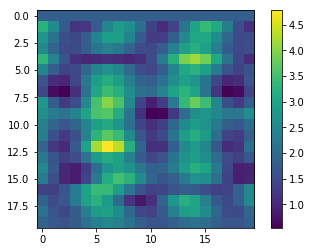

In [299]:
plt.imshow(bell); plt.colorbar()

In [349]:
opt.fun

0.9817331169338186

In [350]:
opt.x

array([1.49808177, 5.70028564])

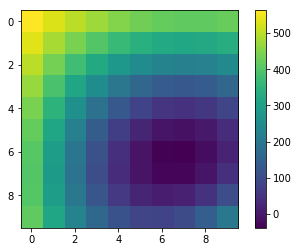

In [605]:
n=13
J = lr(n,1.0,2.5)
#for i in range(n): J[i,i] = 0
K = 0.0*np.ones(n)
a = n*(n-1)*(np.ceil(n/2)-n/2)
b = a/n
c = n*(n-1)/2
d = n/2
ep = -1
bound = 0.5*n*(n-1)*np.ceil((n+2)/2)
p = [a,b,c,d,ep,bound]

beta =pi/4
gamma = 0
theta = pi/5
#bellGen(J,K,0.4,1.25,theta, p)/bound
plt.imshow([[bellGen(J,K, beta,gamma, theta, p) for beta in np.arange(0.1,0.6,0.05)] for gamma in np.arange(1.0,1.5,0.05)]); 
plt.colorbar(); plt.show()

In [561]:
bellGen(J,K, 0.41, 1.3, pi/5, p)/bound

-0.11107653724063599

In [531]:
n=10
a = n*(n-1)*(np.ceil(n/2)-n/2)
b = a/n
c = n*(n-1)/2
d = n/2
ep = -1
bound = 0.5*n*(n-1)*np.ceil((n+2)/2)
p = [a,b,c,d,ep,bound]
theta = pi/5
viol=[]
angles=[]
for alpha in np.arange(2,4,0.2):
    J = lrp(n,1.0,alpha)
    fopt = lambda a: bellGen(J,K,a[0],a[1],theta,p)
    K = 0.0*np.ones(n)
    opt = minimize(fopt, [0.4,1.3], method='BFGS')
    viol.append(opt.fun)
    angles.append(opt.x)

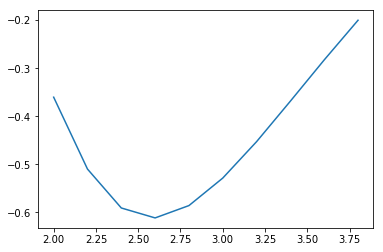

In [532]:
plt.plot(np.arange(2,4,0.2),viol/bound);plt.show()

In [498]:
angles15

[array([0.26167156, 1.11817009]),
 array([0.37021072, 1.18574617]),
 array([0.39123233, 1.22906735]),
 array([0.4164183 , 1.26760461]),
 array([0.43091423, 1.29893222]),
 array([0.43491145, 1.31974492]),
 array([0.43083811, 1.33098838]),
 array([0.42116215, 1.33483852]),
 array([0.40828053, 1.33357745]),
 array([0.39440602, 1.32932744])]

# A more general formula: Any k-body Pauli expectation

In [9]:
1- 2*np.array(list(map(int,bin(10)[2:])))

array([-1,  1, -1,  1])

In [15]:

def trig(J,K, gamma, inds, s):
    c1 = c2 = 1
    rs = np.concatenate((inds[0],inds[1]))
    for l in inds[3]: 
        c1*= np.cos(2*gamma*np.dot(s,J[rs, l]))
    for t in inds[2]:
        c2*= np.sin(2*gamma*np.dot(s,J[rs, t]))
    return c1*c2
def phase(J,K,gamma, inds, s):
    rs = np.concatenate((inds[0],inds[1]))
    ipart = 1.0j**(len(inds[1])-len(inds[2]))
    epart = e^(-2*1.0j*gamma*np.dot(s,K[rs]))
    spart = np.prod(s)
    return ipart*epart*spart
def adder(J,K,gamma, inds, s):
    answer = 0
    lrs = len(inds[0])+len(inds[1])
    for i in range(1<<lrs):
        s = 1- 2*np.array(list(map(int,bin(i)[2:])))
        answer+= phase(J,K,gamma,inds,s)*trig(J,K,gamma,inds,s)
    return answer

In [14]:
A = np.array([[1,1],[2,2]])
A[np.array([0,1]),1]

array([1, 2])